# Butina Clustering
The Butina algorithm as first described in 1999 ([*J. Chem. Inf. Comput. Sci.* **1999**, *39*, 747-750](https://pubs.acs.org/doi/10.1021/ci9803381)) specifically for clustering molecules. 

## Imports & Settings

In [25]:
### Imports
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.manifold import TSNE

In [26]:
### Add the utils directory to the path
sys.path.append(os.path.abspath("../utils"))

from chem import Butina

# Data
The chemical structures of BRD4 inhibitors are encoded in bit vectors. For this data set **Morgan fingerprints** `rdkit.Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect` was used. 






In [27]:
### Load the data
df = pd.read_pickle("data/morgan_2048_df.pkl")
df

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
ID,,,,,,,,,,,,,,,,,,,,,
CHEMBL1232461,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL1233528,0,1,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
CHEMBL1313432,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL1344420,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL1361699,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHEMBL5440963,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL848,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL9,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Method
1) The Tanimoto similarity will be used as distance metric. The only hyperparameter is the **Tanimoto threshold**.
2) All compounds within this threshold are considered **neighbors**. 
3) The compound with the most neighbors is defined as the **centroid** of the first cluster. All its neighbors are cluster members.
4) Compounds assigned to a cluster (both as centroid or cluster member) are ignored for defining the next cluster. Step 3 is repeated until all compounds with neighbors have been assigned to a cluster.
5) Compounds not assigned to a cluster are defined as **singletons**. 


Demonstrative example for Butina clustering

<img src="images/butina.svg" alt="Butina" width="400">

- The Butina algorithm is deterministic.
- Singletons can be within the defined Tanimoto threshold of compounds assigned to a centroid with more neighbors.
- The assumption of this method is that the compound with the most neighbors within a cluster - the centroid - best represents all cluster features. 
- Because the number of clusters is not pre-defined and all cluster members are within the Tanimoto threshold of its centroid clusters tend to be more homogenous compared to other methods. This is because chemical data sets are often distributed very unevenly.  



## Tanimoto Similarity

The Tanimoto similarity between two binary fingerprints **A** and **B** it is defined as:

$$
\text{Tanimoto}(A, B) = \frac{|A \cap B|}{|A| + |B| - |A \cap B|}
$$

Where:
- $ |A \cap B| $ is the number of bits that are 1 in both A and B (i.e., the intersection)
- $ |A| $ is the number of bits that are 1 in A
- $ |B| $ is the number of bits that are 1 in B

<img src="images/tanimoto_venn.svg" alt="Tanimoto Similarity Venn Diagram" width="400">

- Identical molecules have $\text{Tanimoto}(A, A) = 1$
- Very dissimilar molecules have $\text{Tanimoto}(A, B) = 0$
- Tanimoto similarity is closely related to Jaccard distance $ \text{Tanimoto} = 1 - \text{Jaccard} $

## Similarity matrix
A full similarity matrix (containing the similarities between all compounds) is calculated. The computational expensive step for this is the calculation of the intersection matrix ($|A \cap B|$). For the calculation fingerprints as boolean and integers were considered. 

In [28]:
demo_df = pd.DataFrame(
    {
        "ID": ["F1", "F2", "F3", "F4", "F5"],
        "bit_0": [1, 0, 1, 0, 1],
        "bit_1": [1, 0, 1, 1, 0],
        "bit_2": [0, 1, 0, 1, 0],
        "bit_3": [1, 0, 1, 0, 1],
    }
).set_index("ID")
demo_df

,bit_0,bit_1,bit_2,bit_3
ID,,,,
F1,1,1,0,1
F2,0,0,1,0
F3,1,1,0,1
F4,0,1,1,0
F5,1,0,0,1


**Fingerprints as integers**

When using integers the intersection matrix can be calculated as the dot product. 

In [29]:
X_int = demo_df.to_numpy().astype(int)
intersection_matrix = X_int @ X_int.T
pd.DataFrame(intersection_matrix, index=demo_df.index, columns=demo_df.index)

ID,F1,F2,F3,F4,F5
ID,,,,,
F1,3,0,3,1,2
F2,0,1,0,1,0
F3,3,0,3,1,2
F4,1,1,1,2,0
F5,2,0,2,0,2


**Fingerprints as boolean**

When more memory-efficient boolean values are used, the intersection matrix can be calculated using `np.bitwise_and`. However, an additional dimension has to be added to the tensor to enable broadcasting. Therefore, this approach is expected to be less efficient for high dimensionalities (number of compounds > 1000 and number of fingerprints > 1000). 

In [30]:
X_bool = demo_df.to_numpy().astype(bool)
intersection_matrix = np.bitwise_and(X_bool[:, None, :], X_bool[None, :, :]).sum(axis=2)
pd.DataFrame(intersection_matrix, index=demo_df.index, columns=demo_df.index)

ID,F1,F2,F3,F4,F5
ID,,,,,
F1,3,0,3,1,2
F2,0,1,0,1,0
F3,3,0,3,1,2
F4,1,1,1,2,0
F5,2,0,2,0,2


# `Butina` Class
The algorithm is defined in [utils/butina.py](utils/butina.py) as a class containing the methods to perform Butina clustering. 


| Method        | Function Type           | Description                                           |
|---------------|-------------------------|-------------------------------------------------------|
| `__init__()`  | Constructor             | Initializes the class.       |
| `fit()`       | Public                  | Computes the similarity matrix and assigns it as class attribute. |
| `predict()`   | Public                  | Calls  `_assign_next_cluster()` in a while loop until all compounds are assigned to a cluster. |
| `_assign_next_cluster()`       | Helper | Subsets `similarity_df` to compounds not assigned to a cluster and defines the next cluster (the compound with most neighbors is the centroid) |

Class attributes are

| Attribute       | Type         | Description                                       |
|-----------------|--------------|---------------------------------------------------|
| `threshold`     | float        | Similarity thereshold for clustering              |
| `df`            | pd.DataFrame | Input data: binary fingerprints with unique index |
| `similarity_df` | pd.DataFrame | Similarity matrix (symmetrical)                   |
| `compound_df`   | pd.DataFrame | Cluster assignments. Same length and index as df. |
| `cluster_df`    | pd.DataFrame | Cluster summary.                                  |




# Effect of the Tanimoto Threshold
Butina clustering was developed to obtain dense clusters to identify series of compounds and perform scaffold analysis effectively. The way the `Butina` class is constructed the similarity matrix can be calculated once using `Butina.fit()`. Then clustering can be performed testing different threshold values using `Butina.predict()`. 

For this data set a threshold of `0.66` is sensible and might be adjusted slightly for the specific application. Characteristic for this type of clustering is the high proportion of singletons and low populated clusters. 

In [31]:
### Calculating the similarity matrix
model = Butina().fit(df)

Clustering - threshold:  0.33


100%|█████████▉| 99.99999999999946/100 [00:01<00:00, 60.79it/s]  


Number of clusters: 263
Number of singletons: 116
Number of clusters with more than 5 compound: 82
Number of clusters with more than 100 compound: 2
The largest cluster has 125 compounds.


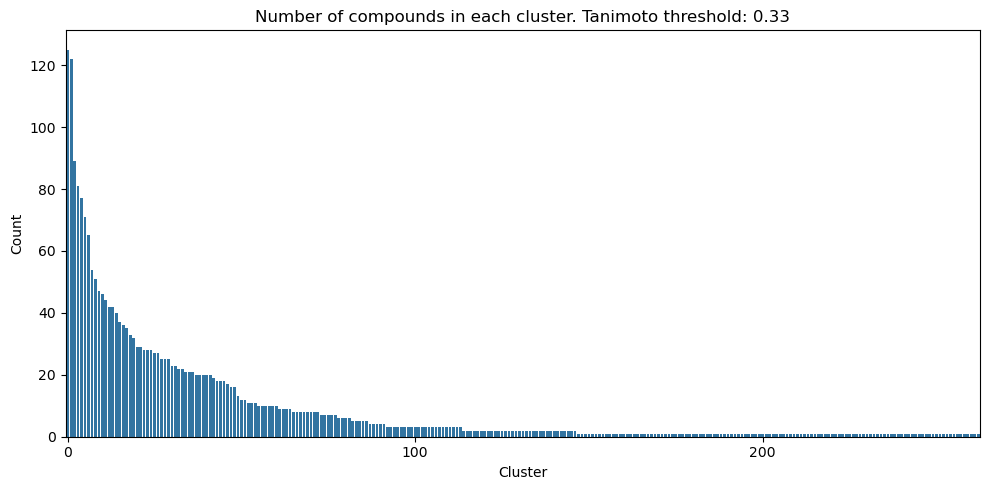

Clustering - threshold:  0.5


100%|█████████▉| 99.999999999999/100 [00:03<00:00, 26.67it/s]   


Number of clusters: 535
Number of singletons: 275
Number of clusters with more than 5 compound: 111
Number of clusters with more than 100 compound: 0
The largest cluster has 64 compounds.


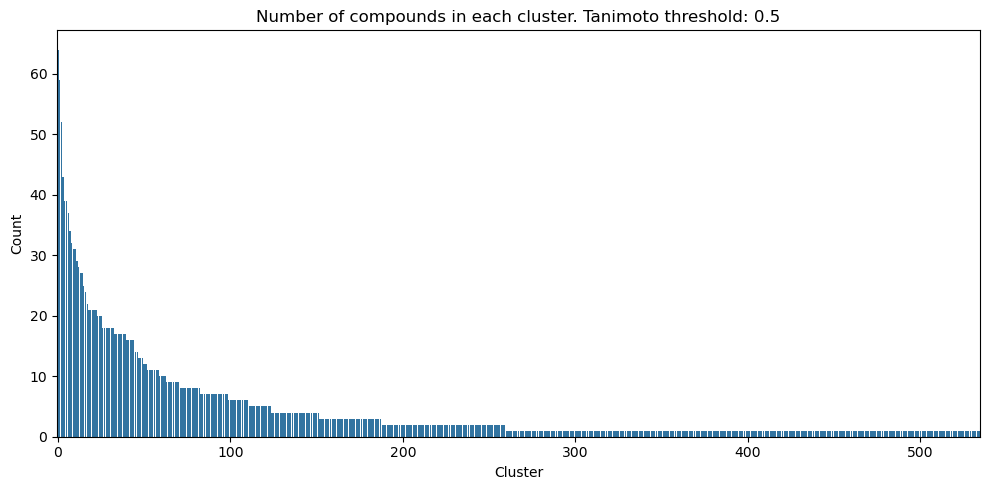

Clustering - threshold:  0.66


100%|█████████▉| 99.9999999999983/100 [00:09<00:00, 10.68it/s]  


Number of clusters: 1118
Number of singletons: 746
Number of clusters with more than 5 compound: 76
Number of clusters with more than 100 compound: 0
The largest cluster has 29 compounds.


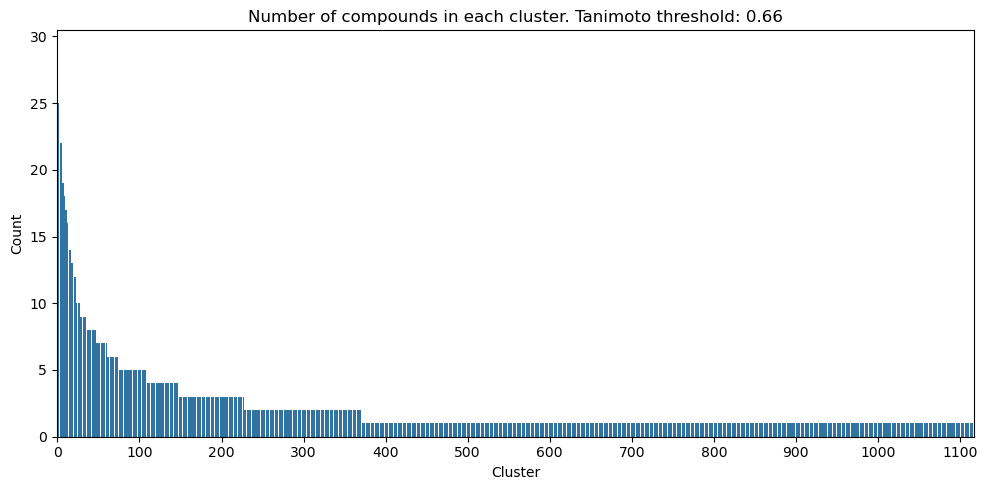

Clustering - threshold:  0.75


100%|█████████▉| 99.99999999999727/100 [00:19<00:00,  5.12it/s] 


Number of clusters: 1687
Number of singletons: 1368
Number of clusters with more than 5 compound: 34
Number of clusters with more than 100 compound: 0
The largest cluster has 16 compounds.


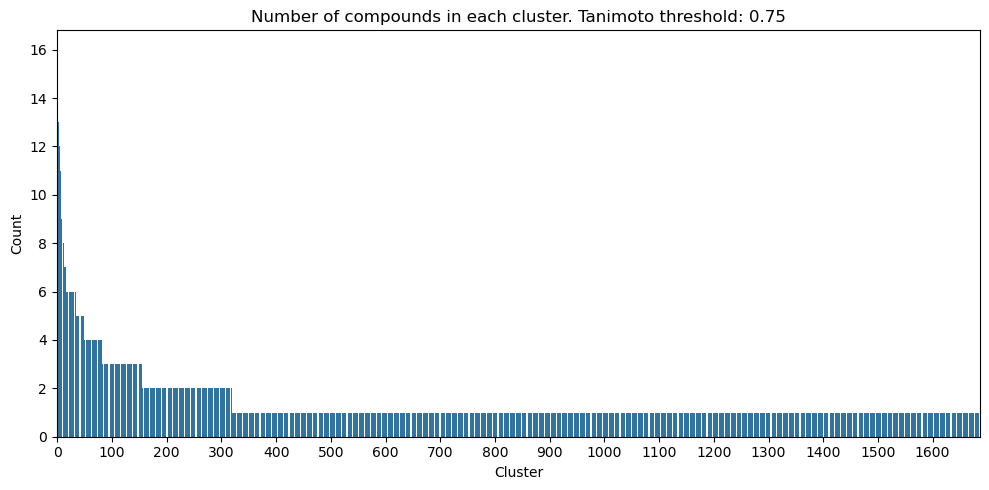

Clustering - threshold:  0.9


100%|█████████▉| 99.99999999999675/100 [00:33<00:00,  2.95it/s]  


Number of clusters: 2338
Number of singletons: 2289
Number of clusters with more than 5 compound: 0
Number of clusters with more than 100 compound: 0
The largest cluster has 4 compounds.


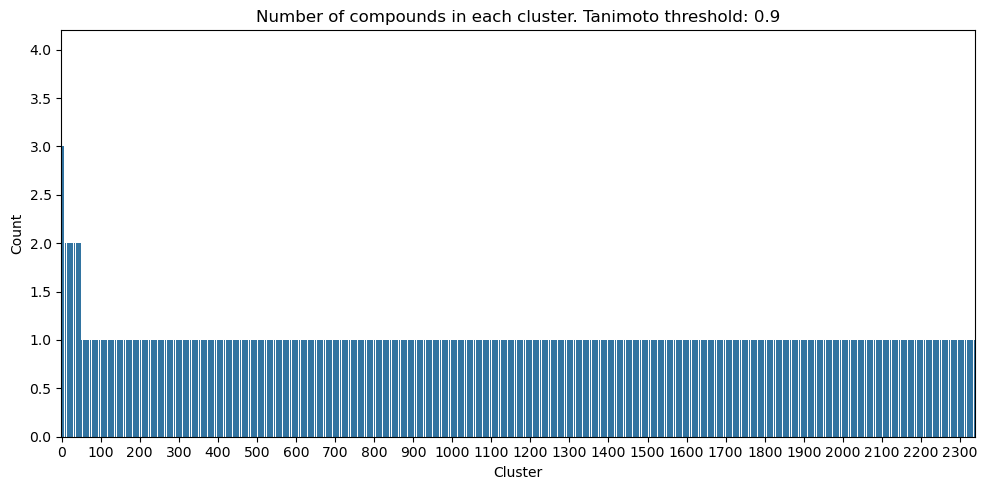

In [ ]:
for tanimoto_threshold in [0.33, 0.5, 0.66, 0.75, 0.9]:

    pred_df = model.predict(threshold=tanimoto_threshold)

    ### Analysis
    count_df = model.cluster_df.value_counts().sort_index()

    print(f"Number of clusters: {pred_df['Cluster'].nunique()}")
    print(f"Number of singletons: {count_df[1]}")
    print(f"Number of clusters with more than 5 compound: {count_df[count_df.index > 5].sum()}")
    print(f"Number of clusters with more than 100 compound: {count_df[count_df.index > 100].sum()}")
    print(f"The largest cluster has {count_df.index[-1]} compounds.")


    ### Countplot
    plt.figure(figsize=(10, 5))
    ax = sns.countplot(x="Cluster", data=pred_df)

    ### Ticks
    ticks = ax.get_xticks()
    ax.set_xticks(ticks[::100])  # Show every 10th cluster
    ax.set_xticklabels([int(t) for t in ticks[::100]], rotation=0)

    ### Title and labels
    plt.title(f"Number of compounds in each cluster. Tanimoto threshold: {model.threshold}")
    plt.xlabel("Cluster")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


# Visualization
For visualization tSNE is used to reduce the dimensionality from 2048 Morgan fingerprints to two. *Note:* the hyperparameters of tSNE affect the cluster density directly. Although this is a good visualization tool, it is of qualitative nature only. 

For readability the compounds are plotted in four subplots:

**Singletons (top left)**

All compounds with singletons (compounds without a cluster) in orange. It is noteworthy that tSNE placed the singletons primarily in the center of the plot. 

**Large Clusters (top right)**

Only clusters with 7 members and more are shown. Each color represents one cluster. The plot demonstrates that tSNE and the custom Butina algorithm are in agreement. 

**Medium Clusters (bottom left)**

Only clusters with 4-7 members are shown. Each color represents one cluster. Like large clusters the medium clusters are located towards the periphery by tSNE. 

**Small Clusters (bottom right)**

Only clusters with 2-3 members are shown. Each color represents one cluster. The clusters are evenly distributed across the tSNE plot. 

In [60]:
### Clustering with the selected threshold
plot_df = model.predict(threshold=0.66).copy()

### Bin cluster sizes
large_clusters = model.cluster_df.loc[model.cluster_df >= 7].index
medium_clusters = model.cluster_df.loc[(model.cluster_df >= 4) & (model.cluster_df < 7)].index
small_clusters = model.cluster_df.loc[(model.cluster_df >= 2) & (model.cluster_df < 4)].index

### Boolean masks for cluster sizes
large_mask = plot_df['Cluster'].isin(large_clusters)
medium_mask = plot_df['Cluster'].isin(medium_clusters)
small_mask = plot_df['Cluster'].isin(small_clusters)

Clustering - threshold:  0.66


100%|█████████▉| 99.9999999999983/100 [00:10<00:00,  9.95it/s]  


In [61]:
### Dimensionality reduction for visualization
tsne = TSNE(n_components=2, random_state=0, perplexity=10)
plot_df[['tsne_x', 'tsne_y']] = tsne.fit_transform(df)


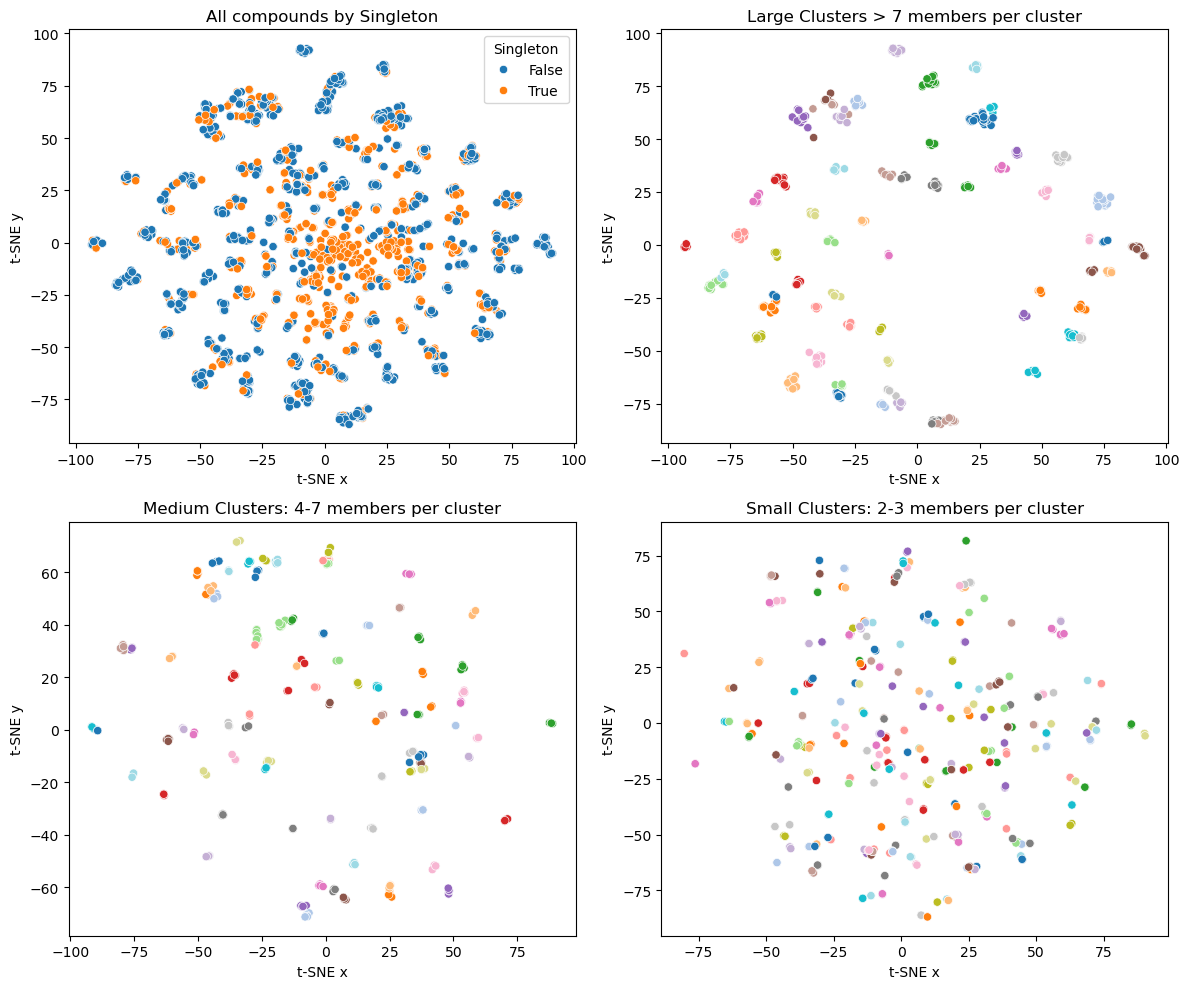

In [63]:
### Plotting
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2 rows, 2 cols
axes = axes.flatten()  # flatten for easier indexing

# Plot 1: Top-left — all data by Singleton
sns.scatterplot(
    x="tsne_x",
    y="tsne_y",
    hue="Singleton",
    data=plot_df,
    legend="full",
    ax=axes[0],
)
axes[0].set_title("All compounds by Singleton")
axes[0].set_xlabel("t-SNE x")
axes[0].set_ylabel("t-SNE y")

# Plot 2–4: Loop over masks
masks = [large_mask, medium_mask, small_mask]
titles = ["Large Clusters > 7 members per cluster", "Medium Clusters: 4-7 members per cluster", "Small Clusters: 2-3 members per cluster"]

for i, (mask, title) in enumerate(zip(masks, titles), start=1):
    sns.scatterplot(
        x="tsne_x",
        y="tsne_y",
        hue="Cluster",
        data=plot_df.loc[mask],
        legend=None,
        palette="tab20",
        ax=axes[i],
    )
    axes[i].set_title(title)
    axes[i].set_xlabel("t-SNE x")
    axes[i].set_ylabel("t-SNE y")

plt.tight_layout()
plt.show()


# Export Analysis


In [67]:
### Save the results
plot_df.to_pickle("data/butina_clusters_66.pkl")